## Messing around with reinforcement learning and multi-agent trading

In [38]:
import numpy as np
import torch
from itertools import product
from collections import defaultdict

### Q class

In [39]:
class Q_table:

    def __init__(self,
                 Np = 31,
                 Nv = 10, 
                 Nx = 15,
                 initial_values = None):

        self.Np = range(Np)
        self.Nv = range(Nv)

        self.states = list(product(self.Np, self.Nv))

        self.Q = {s:np.zeros(Nx) for s in self.states}

        # if initial_values is not None:
        #     self.Q = initial_values
        
    def get_Q_value(self, state, action):
        return self.Q[state][action]

    def get_best_action(self, state):
        return np.argmax(self.Q[state])

    def get_best_value(self, state):
        return np.max(self.Q[state])

    def update(self, state, action, value):
        self.Q[state][action] = value

### Fixed-point iteration methods for solving discretization

In [40]:
def solve_chiN(I, xi, sigma_u, sigma_v, theta, tol=1e-12, max_iter=10000):
    """
    Solve for the noncollusive slope chi^N in the Kyle-type model.

    We use the 3-equation system from Section 3.2 in the paper:
      (1) chi^N = 1 / [(I+1)*lambda^N]
      (2) lambda^N = [theta * gamma^N + xi] / (theta + xi^2)
      (3) gamma^N = (I*chi^N) / [(I*chi^N)^2 + (sigma_u/sigma_v)^2]

    We do simple fixed-point iteration over chi^N.

    Returns:
      float: chi^N
      float: lambda^N
    """
    chi = 0.1  # Arbitrary initial guess
    for _ in range(max_iter):
        # Given chi, compute gamma^N:
        gamma = (I * chi) / ((I * chi)**2 + (sigma_u / sigma_v)**2)

        # Then lambda^N:
        lam = (theta * gamma + xi) / (theta + xi**2)

        # Then the updated chi^N:
        new_chi = 1.0 / ((I + 1) * lam)

        if abs(new_chi - chi) < tol:
            return new_chi, lam
        chi = new_chi

    raise RuntimeError("solve_chiN did not converge within max_iter")


def solve_chiM(I, xi, sigma_u, sigma_v, theta, tol=1e-12, max_iter=10000):
    """
    Solve for the *perfect-collusion* slope chi^M in the Kyle-type model.

    From Section 3.3 in the paper:
      (1) chi^M = 1 / [2*I * lambda^M]
      (2) lambda^M = [theta * gamma^M + xi] / (theta + xi^2)
      (3) gamma^M = (I*chi^M) / [(I*chi^M)^2 + (sigma_u/sigma_v)^2]

    Similar fixed-point iteration as above.
    """
    chi = 0.1  # Arbitrary initial guess
    for _ in range(max_iter):
        gamma = (I * chi) / ((I * chi)**2 + (sigma_u / sigma_v)**2)
        lam = (theta * gamma + xi) / (theta + xi**2)
        new_chi = 1.0 / (2.0 * I * lam)

        if abs(new_chi - chi) < tol:
            return new_chi, lam
        chi = new_chi

    raise RuntimeError("solve_chiM did not converge within max_iter")

### Informed (potentially) Collusive Agents

In [41]:
I = 3                       # Global variable for number of informed traders

class InformedAgent:

    def __init__(
            self, 
            Np = 31,        # number of grid points for the price
            Nv = 10,        # number of grid points for the value
            Nx = 15,        # number of grid points for the order flow
            
            rho = 0.95,     # discount factor
            alpha = 0.01,   # learning rate (forgetting factor)
            beta = 1e-5,    # epsilon decay rate
            
            sigma_v = 1,    # volatility of the security value
            v_bar = 1,      # expected value of the security
            sigma_u = 0.1,  # volatility of the order flow
            xi = 500,       # risk aversion parameter
            theta = 0.1,    # market maker's pricing error risk aversion parameter
            iota = 0.1      # span of the grid around the optimal price
            ):
        
        # parameters
        self.n_actions = Nx
        self.Np = Np
        self.Nv = Nv
        self.n_states = Np * Nv

        self.rho = rho
        self.alpha = alpha
        self.beta = beta

        self.sigma_v = sigma_v
        self.v_bar = v_bar
        self.sigma_u = sigma_u
        self.xi = xi
        self.theta = theta
        self.iota = iota

        # Q-table for RL
        self.Q = Q_table(Np = Np, Nv = Nv, Nx = Nx)

        # state count dictionary for epsilon decay
        self.state_count = defaultdict(int)

        # discretization of states
        self.get_discrete_states()

        # initialize Q-table
        self.initialize_Q()

    
    def get_epsilon(self, state):
        v = self.state_count[state]
        self.state_count[state] += 1
        return np.exp(-self.beta * v)
    
    def get_action(self, state):
        epsilon = self.get_epsilon(state)
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_actions)
        else:
            return self.Q.get_best_action(state)
        
    def update(self, state, action, reward, next_state):
        learning = self.alpha * (reward + self.rho * self.Q.get_best_value(next_state))
        memory = (1 - self.alpha) * self.Q.get_Q_value(state, action)
        value = learning + memory
        self.Q.update(state, action, value)
    
    def get_grid_point_values_v(self):
        """
        Returns a zero indexed dictionary of the grid points for the state space of v
        """
        standard_normal = torch.distributions.Normal(0, 1)
        grid_point = [(2 * k - 1) / (2 * self.Nv) for k in range(1, self.Nv + 1)]
        values = standard_normal.icdf(torch.tensor(grid_point))
        return {idx: float(self.v_bar + self.sigma_v * value) for idx, value in enumerate(values)}
    
    def get_grid_point_values_x(self):
        self.chiN, self.lambdaN = solve_chiN(I = I, xi = self.xi, sigma_u = self.sigma_u, sigma_v = self.sigma_v, theta = self.theta)
        self.chiM, self.lambdaM = solve_chiM(I = I, xi = self.xi, sigma_u = self.sigma_u, sigma_v = self.sigma_v, theta = self.theta)
        self.x_n, self.x_m = self.chiN, self.chiM # assuming v - v_bar = 1
        span_x = abs(self.x_n - self.x_m)
        low, high = -max(self.x_n, self.x_m) - self.iota * span_x, max(self.x_n, self.x_m) + self.iota * span_x
        values = np.linspace(low, high, self.n_actions)
        return {idx: float(val) for idx, val in enumerate(values)}
    
    def get_grid_point_values_p(self):
        try:
            lambda_for_p = max(self.lambdaN, self.lambdaM)
        except:
            raise ValueError("Call get_grid_point_values_x() first")
        ph = self.v_bar + lambda_for_p * (I * max(self.x_n, self.x_m) + self.sigma_u * 1.96)
        pl = self.v_bar - lambda_for_p * (I * max(self.x_n, self.x_m) + self.sigma_u * 1.96)
        span_p = ph - pl
        values = np.linspace(pl - self.iota * span_p, ph + self.iota * span_p, self.Np)
        return {idx: float(val) for idx, val in enumerate(values)}
    
    def get_discrete_states(self):
        self.v_discrete = self.get_grid_point_values_v()
        self.x_discrete = self.get_grid_point_values_x()
        self.p_discrete = self.get_grid_point_values_p()

    def continuous_to_discrete(self, p, v):
        p_idx = min(self.p_discrete, key=lambda x: abs(self.p_discrete[x] - p))
        v_idx = min(self.v_discrete, key=lambda x: abs(self.v_discrete[x] - v))
        return p_idx, v_idx

    def initialize_Q(self):
        for p in range(self.Np):
            for v in range(self.Nv):
                state = (p, v)
                for x in range(self.n_actions):
                    value = 0
                    for x_i in range(self.n_actions):
                        value += self.v_discrete[v] - (self.v_bar + self.lambdaN * (self.x_n + (I - 1) * self.x_discrete[x_i]))
                    value *= self.x_discrete[x] / ((1 - self.rho) * self.n_actions)
                    self.Q.update(state, x, value)

{0: -0.6448533535003662, 1: -0.03643333911895752, 2: 0.32551026344299316, 3: 0.6146795153617859, 4: 0.8743386268615723, 5: 1.1256613731384277, 6: 1.3853204250335693, 7: 1.6744897365570068, 8: 2.036433696746826, 9: 2.644853353500366}
{0: -129.16665166667082, 1: -110.71427285714641, 2: -92.26189404762201, 3: -73.80951523809762, 4: -55.35713642857321, 5: -36.90475761904881, 6: -18.45237880952442, 7: 0.0, 8: 18.45237880952439, 9: 36.90475761904878, 10: 55.3571364285732, 11: 73.80951523809759, 12: 92.26189404762198, 13: 110.7142728571464, 14: 129.16665166667082}
{0: 0.09952935981182495, 1: 0.15956073582436997, 2: 0.21959211183691496, 3: 0.27962348784946, 4: 0.339654863862005, 5: 0.39968623987455, 6: 0.45971761588709503, 7: 0.5197489918996401, 8: 0.579780367912185, 9: 0.6398117439247301, 10: 0.6998431199372751, 11: 0.7598744959498202, 12: 0.8199058719623651, 13: 0.8799372479749101, 14: 0.9399686239874552, 15: 1.0, 16: 1.060031376012545, 17: 1.12006275202509, 18: 1.1800941280376351, 19: 1.240

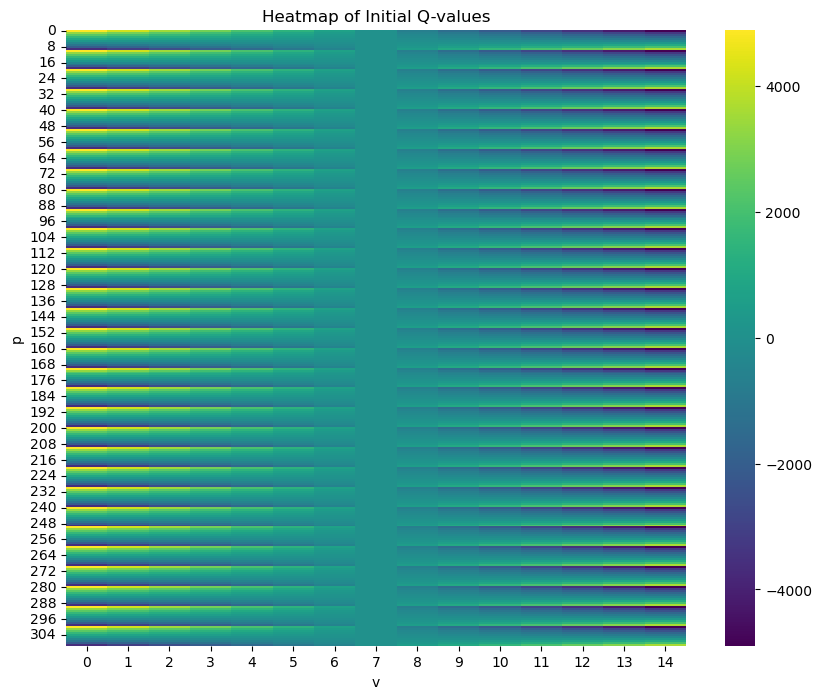

In [42]:
import seaborn as sns

a = InformedAgent(Nv = 10)
print(a.v_discrete)
print(a.x_discrete)
print(a.p_discrete)
q = a.Q.Q
import matplotlib.pyplot as plt

# Extract Q-values for a specific action (e.g., action 0)
q_values = np.array([q[state] for state in a.Q.states])

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(q_values, cmap="viridis")
plt.title("Heatmap of Initial Q-values")
plt.xlabel("v")
plt.ylabel("p")
plt.show()

### Preferred Habitat Investor

In [43]:
class PreferredHabitatAgent:

    def __init__(self, xi = 500, v_bar = 1):
        self.xi = xi
        self.v_bar = v_bar

    def get_action(self, pt):
        z = -self.xi * (pt - self.v_bar)
        return z
    
    

### Adaptive Market Makers

In [44]:
class CircularBuffer:
    """
    Circular buffer for storing historical data.
    """
    def __init__(self, size):
        self.size = size
        self.buffer = np.zeros(size)
        self.index = 0

    def add(self, value):
        self.buffer[self.index] = value
        self.index = (self.index + 1) % self.size

    def get(self):
        return np.concatenate((self.buffer[self.index:], self.buffer[:self.index]))

class AdaptiveMarketMaker:

    def __init__(self, theta = 0.1, Tm = 10000):
        self.theta = theta
        self.Tm = Tm

        self.vars_ = ['v','p','z','y']
        self.historical_data = {var: CircularBuffer(size = self.Tm) for var in self.vars_}

    def OLS(self, y, X):
        """
        Perform Ordinary Least Squares (OLS) regression.
        Parameters:
        y (CircularBuffer): The dependent variable.
        X (CircularBuffer): The independent variable(s).
        Returns:
        coef_ (ndarray): The estimated coefficients for the linear regression model.
        """
        y = y.get()
        X = X.get()
        
        X = np.vstack([X, np.ones(len(X))]).T
        coef_, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        return coef_
    
    def determine_price(self, yt):
        """
        Determines the price based on historical data and a given input.
        This method uses Ordinary Least Squares (OLS) regression to calculate
        yt (float): The input value for which the price needs to be determined.
        Returns:
        float: The determined price based on the input `yt`.
        """

        xi_1, _ = self.OLS(self.historical_data['z'], self.historical_data['p'])
        gamma_1, gamma_0 = self.OLS(self.historical_data['v'], self.historical_data['y'])
        lambda_ = (xi_1 + self.theta * gamma_1) / (xi_1**2 + self.theta)
        # print(lambda_)
        price = gamma_0 + lambda_ * yt
        return price
    
    def update(self, vt, pt, zt, yt):
        """
        Updates the historical data with the given values.
        Parameters:
        vt (float): The value of `v` at time `t`.
        pt (float): The value of `p` at time `t`.
        zt (float): The value of `z` at time `t`.
        yt (float): The value of `y` at time `t`.
        """
        for var, value in zip(self.vars_, [vt, pt, zt, yt]):
            self.historical_data[var].add(value)

### Noise Trader

In [45]:
class NoiseAgent:
    def __init__(self, sigma = 0.1):
        self.sigma = sigma

    def get_action(self):
        return np.random.normal(scale = self.sigma)

In [ ]:
from tqdm import tqdm

def get_next_v(v_bar = 1, sigma_v = 1):
    return v_bar + np.random.normal(scale = sigma_v)

def simulate(
        T = 1000000, 
        I = 3,
        Np = 31,        # number of grid points for the price
        Nv = 10,        # number of grid points for the value
        Nx = 15,        # number of grid points for the order flow
        sigma_u = 0.1,   # volatility of the NoiseAgents
        continue_simulation = False # continue simulation if True
        ):
    if type(continue_simulation) == str:
        log = np.load(continue_simulation, allow_pickle=True).item()
        v_hist = log["v"]
        p_hist = log["p"]
        z_hist = log["z"]
        x_hist = log["x"]
        y_hist = log["y"]
        v_hist = np.concatenate((v_hist, np.zeros(T)))
        p_hist = np.concatenate((p_hist, np.zeros(T)))
        z_hist = np.concatenate((z_hist, np.zeros(T)))
        x_hist = np.concatenate((x_hist, np.zeros((I, T))), axis=1)
        y_hist = np.concatenate((y_hist, np.zeros((I, T))), axis=1)
        profit_hist = np.concatenate((profit_hist, np.zeros((I, T))), axis=1)

        profit_hist = log["profit"]
        informed_agents = log["agents"]["informed"]
        noise_agent = log["agents"]["noise"]
        preferred_habitat_agent = log["agents"]["preferred_habitat"]
        market_maker = log["agents"]["market_maker"]

        _state = log["last_state"]
    elif continue_simulation == False:

        market_maker = AdaptiveMarketMaker()
        noise_agent = NoiseAgent(sigma = sigma_u)
        preferred_habitat_agent = PreferredHabitatAgent()
        informed_agents = [InformedAgent(Np = Np, Nv = Nv, Nx = Nx) for _ in range(I)]
        _state = (np.random.choice(Np), np.random.choice(Nv))

        # log histories
        v_hist = np.zeros(T)
        p_hist = np.zeros(T)
        z_hist = np.zeros(T)
        x_hist = np.zeros((I, T))
        y_hist = np.zeros((I, T))
        profit_hist = np.zeros((I, T))
    else:
        raise ValueError("Invalid value for continue_simulation")

    for t in tqdm(range(T), desc="Simulation Progress"):

        yt = []
        _p, _v = informed_agents[0].p_discrete[_state[0]], informed_agents[0].v_discrete[_state[1]]
        v_hist[t] = _v
        p_hist[t] = _p
        _x = []
        for idx, agent in enumerate(informed_agents):
            x = agent.get_action(_state)
            xd = agent.x_discrete[x]
            yt.append(xd)
            _x.append(x)
            x_hist[idx, t] = xd
            y_hist[idx, t] = yt[-1]

        yt_sum = np.sum(yt) + noise_agent.get_action()
        # print(yt_sum)
        zt = preferred_habitat_agent.get_action(_p)
        z_hist[t] = zt
        market_maker.update(_v, _p, zt, yt_sum)
        pt = market_maker.determine_price(yt_sum)
        vt = get_next_v()
        next_state = informed_agents[0].continuous_to_discrete(pt, vt)
        for idx, agent in enumerate(informed_agents):
            reward = (_v - pt) * yt[idx]
            agent.update(_state, _x[idx], reward, next_state)
            profit_hist[idx, t] = reward

        _state = next_state
    log = {
        "v": v_hist,
        "p": p_hist,
        "z": z_hist,
        "x": x_hist,
        "y": y_hist,
        "profit": profit_hist,
        "last_state": _state
    }
    agents = {
        "informed": informed_agents,
        "noise": noise_agent,
        "preferred_habitat": preferred_habitat_agent,
        "market_maker": market_maker
    }
    return log, agents

In [47]:
log, agents = simulate(Np = 61, Nv = 20, Nx = 30, T = 20000000)

Simulation Progress: 100%|██████████| 20000000/20000000 [1:17:05<00:00, 4324.29it/s]


In [48]:
p0 = log['profit'][0].cumsum()
p1 = log['profit'][1].cumsum()
p2 = log['profit'][2].cumsum()

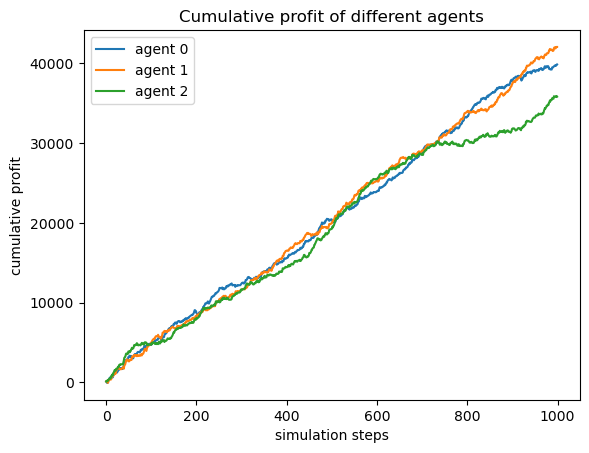

In [69]:
for idx, p in enumerate(log['profit']):
    plt.plot(np.cumsum(p[-1000:]),label = 'agent {0}'.format(idx))
plt.xlabel('simulation steps')
plt.ylabel('cumulative profit')
plt.title('Cumulative profit of different agents')
plt.legend()

In [56]:
action_var = np.var(log['x'], axis = 0)

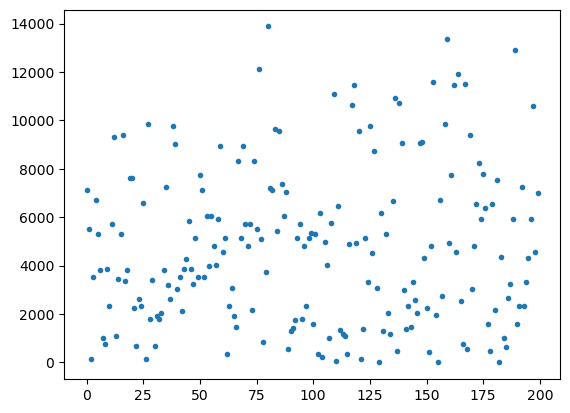

In [64]:
plt.plot(action_var[::100000],'.')

In [104]:
log

{'v': array([0.87433863, 2.64485335, 1.12566137, ..., 1.12566137, 1.67448974,
        0.61467952]),
 'p': array([1.48025101, 1.48025101, 1.48025101, ..., 1.18009413, 0.87993725,
        0.87993725]),
 'z': array([-240.12550405, -240.12550405, -240.12550405, ...,  -90.04706402,
          60.03137601,   60.03137601]),
 'x': array([[ -73.80951524,  -36.90475762,  -92.26189405, ...,   73.80951524,
           36.90475762,  110.71427286],
        [ -55.35713643,  -73.80951524,  129.16665167, ...,    0.        ,
           92.26189405, -110.71427286],
        [-110.71427286, -129.16665167,  -73.80951524, ...,    0.        ,
          -73.80951524, -129.16665167]]),
 'y': array([[ -73.80951524,  -36.90475762,  -92.26189405, ...,   73.80951524,
           36.90475762,  110.71427286],
        [ -55.35713643,  -73.80951524,  129.16665167, ...,    0.        ,
           92.26189405, -110.71427286],
        [-110.71427286, -129.16665167,  -73.80951524, ...,    0.        ,
          -73.80951524, -1